Jack manages two locations for a nationwide
car rental company. Each day, some number of customers arrive at
each location to rent cars. If Jack has a car available, he rents it out and is
credited \$10 by the national company. If he is out of cars at that location,
then the business is lost. Cars become available for renting the day after they
are returned. To help ensure that cars are available where they are needed,
Jack can move them between the two locations overnight, at a cost of \$2 per
car moved. We assume that the number of cars requested and returned at
each location are Poisson random variables, meaning that the probability that
the number is n. Suppose $\lambda$ is 3
and 4 for rental requests at the first and second locations and 3 and 2 for
returns. To simplify the problem slightly, we assume that there can be no
more than 20 cars at each location (any additional cars are returned to the
nationwide company, and thus disappear from the problem) and a maximum
of five cars can be moved from one location to the other in one night. We take
the discount rate to be
 = 0:9 and formulate this as a continuing finite MDP,
where the time steps are days, the state is the number of cars at each location
at the end of the day, and the actions are the net numbers of cars moved
between the two locations overnight.

## MDP

Action : net number of cars moved between the two locations overnight

State : number of cars at each location at the end of the day

time steps: days

In [13]:
from dataclasses import dataclass
from functools import lru_cache
import math

@dataclass(frozen=True)
class JackParams:
    max_cars: int = 20
    max_move: int = 5
    gamma: float = 0.9
    rent_reward: float = 10.0
    move_cost: float = 2.0
    lam_req1: float = 3.0
    lam_req2: float = 4.0
    lam_ret1: float = 3.0
    lam_ret2: float = 2.0
    poisson_cutoff: int = 11  # debug: 10-12; higher = slower

class JacksCarRentalEnv:
    def __init__(self, p: JackParams):
        self.p = p
        self.states = [(i, j) for i in range(p.max_cars + 1) for j in range(p.max_cars + 1)]
        self._pmf_cache = {}  # (lam) -> list[prob] length cutoff+1

    def actions(self, s):
        n1, n2 = s
        acts = []
        for a in range(-self.p.max_move, self.p.max_move + 1):
            if a > 0 and n1 < a:
                continue
            if a < 0 and n2 < -a:
                continue
            # after move must stay >=0 and <=max_cars (it will if above holds + bounds)
            acts.append(a)
        return acts

    def poisson_pmf(self, lam):
        # returns probs for n=0..cutoff, normalized
        if lam in self._pmf_cache:
            return self._pmf_cache[lam]
        K = self.p.poisson_cutoff
        probs = []
        for n in range(K + 1):
            probs.append(math.exp(-lam) * (lam ** n) / math.factorial(n))
        s = sum(probs)
        probs = [x / s for x in probs]  # renormalize truncated mass
        self._pmf_cache[lam] = probs
        return probs

    @lru_cache(maxsize=None)
    def transition_and_reward_distribution(self, s, a):
        """
        Returns:
          trans_probs: dict[(n1_next, n2_next)] -> prob
          exp_reward: expected immediate reward for (s,a)
        """
        n1, n2 = s
        n1m, n2m = n1 - a, n2 + a

        # Original move cost (modify later for Exercise 4.5)
        move_cost = self.p.move_cost * abs(a)
        base_cost = -move_cost

        pmf_req1 = self.poisson_pmf(self.p.lam_req1)
        pmf_req2 = self.poisson_pmf(self.p.lam_req2)
        pmf_ret1 = self.poisson_pmf(self.p.lam_ret1)
        pmf_ret2 = self.poisson_pmf(self.p.lam_ret2)

        trans = {}
        exp_r = 0.0
        K = self.p.poisson_cutoff

        for req1 in range(K + 1):
            p_req1 = pmf_req1[req1]
            rent1 = min(n1m, req1)
            for req2 in range(K + 1):
                p_req2 = pmf_req2[req2]
                rent2 = min(n2m, req2)

                reward_rentals = self.p.rent_reward * (rent1 + rent2)
                n1_after = n1m - rent1
                n2_after = n2m - rent2

                for ret1 in range(K + 1):
                    p_ret1 = pmf_ret1[ret1]
                    for ret2 in range(K + 1):
                        p_ret2 = pmf_ret2[ret2]
                        prob = p_req1 * p_req2 * p_ret1 * p_ret2
                        n1_next = min(self.p.max_cars, n1_after + ret1)
                        n2_next = min(self.p.max_cars, n2_after + ret2)
                        s_next = (n1_next, n2_next)

                        r = reward_rentals + base_cost
                        trans[s_next] = trans.get(s_next, 0.0) + prob
                        exp_r += prob * r

        # trans already sums to ~1 due to normalization
        return trans, exp_r

    def expected_backup(self, s, a, V):
        if not isinstance(V, dict):
          raise TypeError("V must be a dict mapping states to values")

        trans, exp_r = self.transition_and_reward_distribution(s, a)
        exp_v = 0.0
        for s_next, prob in trans.items():
            exp_v += prob * V[s_next]
        return exp_r + self.p.gamma * exp_v


In [14]:
env = JackCarRentalEnv(JackParams())
V = {(i, j): 0.0 for i in range(21) for j in range(21)}

In [15]:
env.expected_backup((0, 0), 0, V)

0.0

In [21]:
env.expected_backup((20, 5), 0, V)

65.87740973359428

In [17]:
env.expected_backup((10, 10), 5, V)

58.57521849566663

In [18]:
env.expected_backup((20, 20), 0, V)

69.91631901796316

## Policy Iteration

In [23]:


## policy evaluation

def policy_evaluation(env, V, p, theta_eval) -> dict:
  theta = theta_eval
  while True:
    delta = 0
    for s in env.states:
      v = V[s]
      V[s] = env.expected_backup(s, p[s], V)
      delta = max(delta, abs(v - V[s]))
    if delta < theta:
      break
  return V

## policy improvement

def policy_improvement(env, V, p) -> dict:
  policy_stable = True
  for s in env.states:
    old_action = p[s]
    best_action = old_action
    best_value = env.expected_backup(s, best_action, V)
    for a in env.actions(s):
      val = env.expected_backup(s, a, V)
      if val > best_value:
        best_value = val
        best_action = a
    p[s] = best_action
    if best_action != old_action:
      policy_stable = False
  return p, policy_stable

## policy iteration

def policy_iteration(env, theta_eval = 1e-3):
  V = {(i, j): 0.0 for i in range(21) for j in range(21)}
  p = {s: 0 for s in env.states}
  while True:
    V = policy_evaluation(env, V, p, theta_eval)
    p, policy_stable = policy_improvement(env, V, p)
    if policy_stable:
      break
  return V, p

In [40]:
%%time
env = JackCarRentalEnv(JackParams())
V, p = policy_iteration(env)

CPU times: user 1min 6s, sys: 139 ms, total: 1min 7s
Wall time: 1min 7s


In [33]:
import numpy as np
import matplotlib.pyplot as plt
def plot_heatmap(V, title = "Value Function Heatmap (Jack's Car Rental)",
                 xlabel = "Cars at location 2 (j)", ylabel = "Cars at location 1 (i)"):
  # V is your dict: {(i,j): value}
  max_i = max(i for i, j in V.keys())
  max_j = max(j for i, j in V.keys())

  grid = np.full((max_i + 1, max_j + 1), np.nan)
  for (i, j), val in V.items():
      grid[i, j] = val

  plt.figure(figsize=(10, 8))
  im = plt.imshow(grid, origin="lower", aspect="auto")
  plt.colorbar(im, label="Value")
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.tight_layout()
  plt.show()



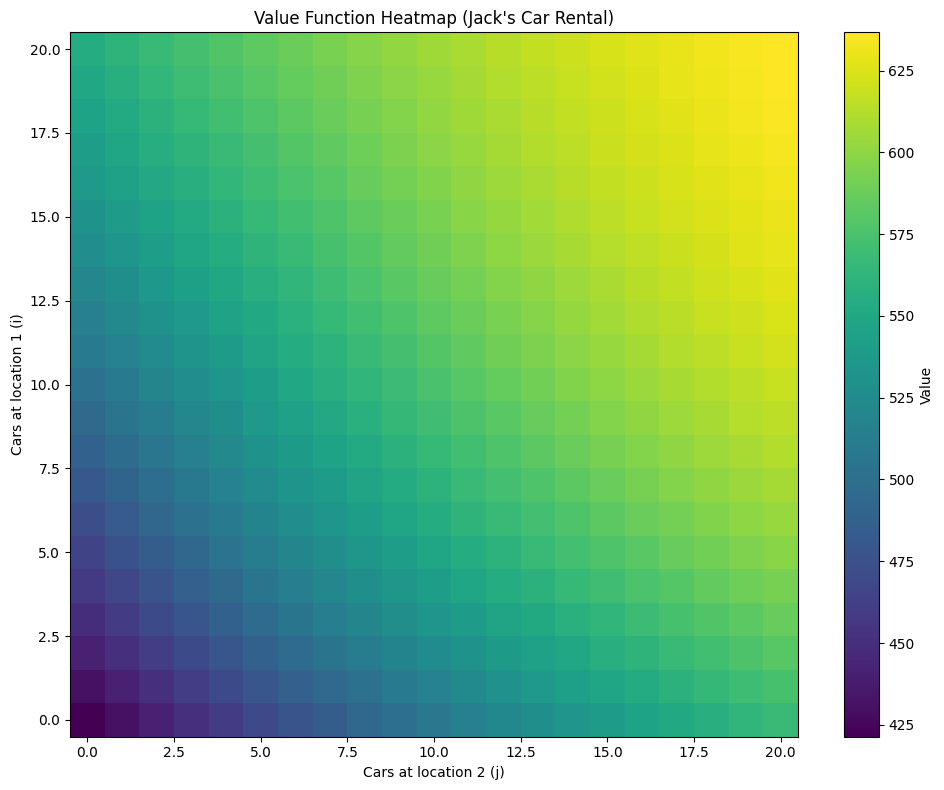

In [34]:
plot_heatmap(V)

more inventory means more rentals captured, but it saturates because demand is limited by Poisson rates and cars cap at 20.

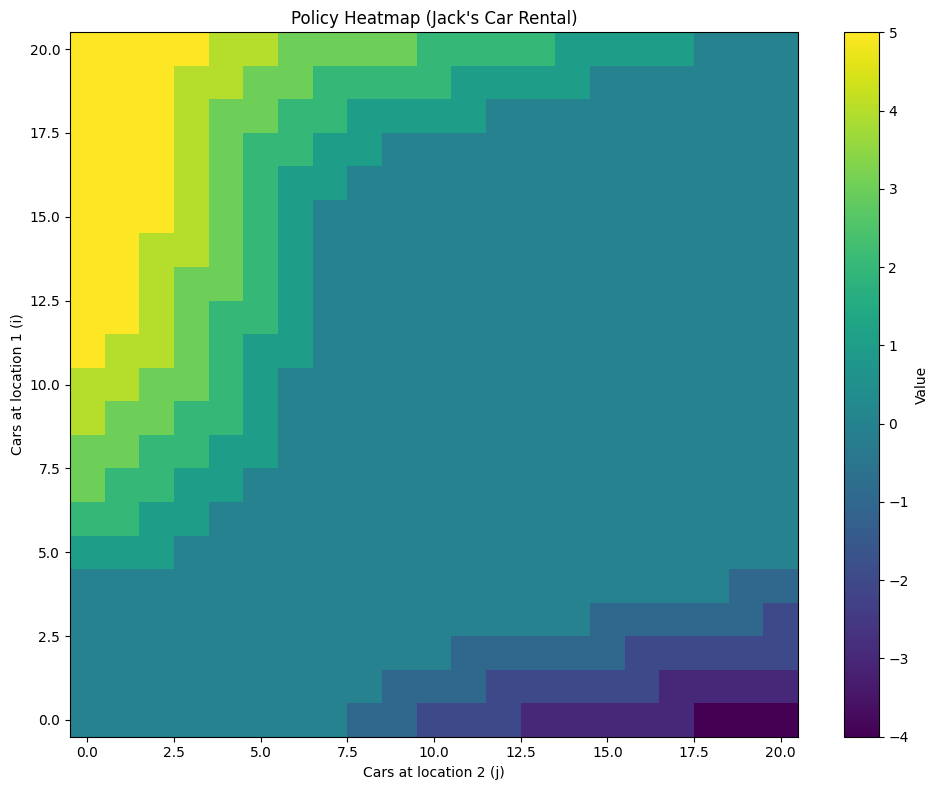

In [35]:
plot_heatmap(p, title = "Policy Heatmap (Jack's Car Rental)",
                 xlabel = "Cars at location 2 (j)", ylabel = "Cars at location 1 (i)")

higher values when you have more cars total, with diminishing returns near the caps

## Value iteration

In [36]:
def value_iteration(env, theta_eval = 1e-3):
  V = {(i, j): 0.0 for i in range(21) for j in range(21)}
  p = {s: 0 for s in env.states}
  while True:
    delta = 0.0
    for s in env.states:
      val = V[s]
      V[s] = max(env.expected_backup(s, a, V) for a in env.actions(s))
      delta = max(delta, abs(val - V[s]))
    if delta < theta_eval:
      break
  for s in env.states:
    p[s] = max(env.actions(s), key = lambda a: env.expected_backup(s, a, V))
  return V, p

In [37]:
%%time
env = JackCarRentalEnv(JackParams())
V, p = value_iteration(env)

CPU times: user 1min 13s, sys: 153 ms, total: 1min 13s
Wall time: 1min 15s


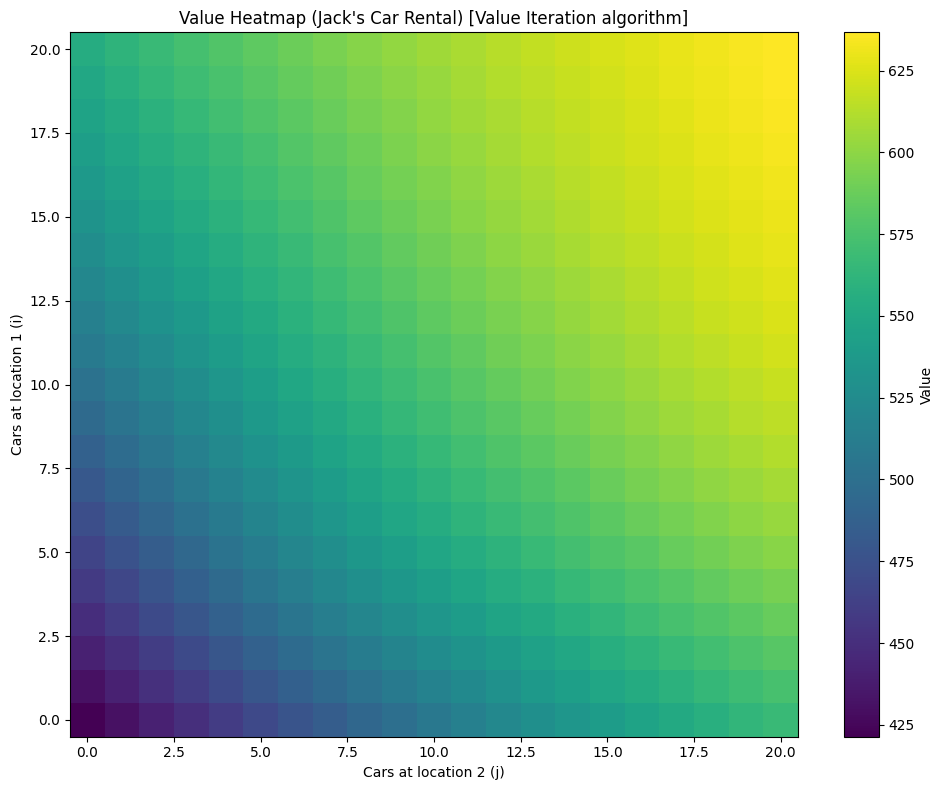

In [39]:
plot_heatmap(V, title = "Value Heatmap (Jack's Car Rental) [Value Iteration algorithm]",
                 xlabel = "Cars at location 2 (j)", ylabel = "Cars at location 1 (i)")

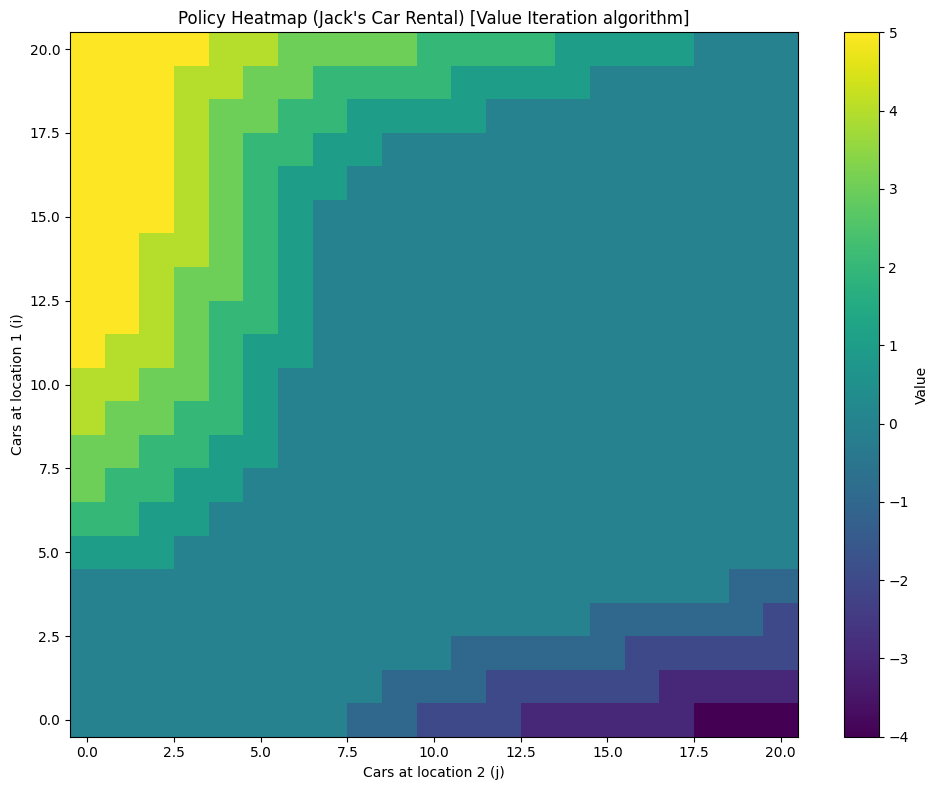

In [38]:
plot_heatmap(p, title = "Policy Heatmap (Jack's Car Rental) [Value Iteration algorithm]",
                 xlabel = "Cars at location 2 (j)", ylabel = "Cars at location 1 (i)")

## Addition of constraints

One of Jack's
employees at the first location rides a bus home each night and lives near
the second location. She is happy to shuttle one car to the second location
for free. Each additional car still costs \$2, as do all cars moved in the other
direction. In addition, Jack has limited parking space at each location. If
more than 10 cars are kept overnight at a location (after any moving of cars),
then an additional cost of \$4 must be incurred to use a second parking lot
(independent of how many cars are kept there)

In [41]:
from dataclasses import dataclass
from functools import lru_cache
import math

@dataclass(frozen=True)
class JackParams:
    max_cars: int = 20
    max_move: int = 5
    gamma: float = 0.9
    rent_reward: float = 10.0
    move_cost: float = 2.0
    lam_req1: float = 3.0
    lam_req2: float = 4.0
    lam_ret1: float = 3.0
    lam_ret2: float = 2.0
    poisson_cutoff: int = 11  # debug: 10-12; higher = slower

    free_one_car_1_to_2: bool = False
    parking_penalty: bool = False
    parking_threshold: int = 10
    parking_cost: float = 4.0

class JacksCarRentalEnv:
    def __init__(self, p: JackParams):
        self.p = p
        self.states = [(i, j) for i in range(p.max_cars + 1) for j in range(p.max_cars + 1)]
        self._pmf_cache = {}  # (lam) -> list[prob] length cutoff+1

    def actions(self, s):
        n1, n2 = s
        acts = []
        for a in range(-self.p.max_move, self.p.max_move + 1):
            if a > 0 and n1 < a:
                continue
            if a < 0 and n2 < -a:
                continue
            # after move must stay >=0 and <=max_cars (it will if above holds + bounds)
            acts.append(a)
        return acts

    def poisson_pmf(self, lam):
        # returns probs for n=0..cutoff, normalized
        if lam in self._pmf_cache:
            return self._pmf_cache[lam]
        K = self.p.poisson_cutoff
        probs = []
        for n in range(K + 1):
            probs.append(math.exp(-lam) * (lam ** n) / math.factorial(n))
        s = sum(probs)
        probs = [x / s for x in probs]  # renormalize truncated mass
        self._pmf_cache[lam] = probs
        return probs

    @lru_cache(maxsize=None)
    def transition_and_reward_distribution(self, s, a):
        """
        Returns:
          trans_probs: dict[(n1_next, n2_next)] -> prob
          exp_reward: expected immediate reward for (s,a)
        """
        n1, n2 = s
        n1m, n2m = n1 - a, n2 + a


        if self.p.free_one_car_1_to_2 and a > 0 :
          move_cost = self.p.move_cost * max(a -1, 0)
        else:
          move_cost = self.p.move_cost * abs(a)
        parking_cost = 0.0
        if self.p.parking_penalty:
          if n1m > self.p.parking_threshold:
            parking_cost += self.p.parking_cost
          if n2m > self.p.parking_threshold:
            parking_cost += self.p.parking_cost
        base_cost = -move_cost - parking_cost

        pmf_req1 = self.poisson_pmf(self.p.lam_req1)
        pmf_req2 = self.poisson_pmf(self.p.lam_req2)
        pmf_ret1 = self.poisson_pmf(self.p.lam_ret1)
        pmf_ret2 = self.poisson_pmf(self.p.lam_ret2)

        trans = {}
        exp_r = 0.0
        K = self.p.poisson_cutoff

        for req1 in range(K + 1):
            p_req1 = pmf_req1[req1]
            rent1 = min(n1m, req1)
            for req2 in range(K + 1):
                p_req2 = pmf_req2[req2]
                rent2 = min(n2m, req2)

                reward_rentals = self.p.rent_reward * (rent1 + rent2)
                n1_after = n1m - rent1
                n2_after = n2m - rent2

                for ret1 in range(K + 1):
                    p_ret1 = pmf_ret1[ret1]
                    for ret2 in range(K + 1):
                        p_ret2 = pmf_ret2[ret2]
                        prob = p_req1 * p_req2 * p_ret1 * p_ret2
                        n1_next = min(self.p.max_cars, n1_after + ret1)
                        n2_next = min(self.p.max_cars, n2_after + ret2)
                        s_next = (n1_next, n2_next)

                        r = reward_rentals + base_cost
                        trans[s_next] = trans.get(s_next, 0.0) + prob
                        exp_r += prob * r

        # trans already sums to ~1 due to normalization
        return trans, exp_r

    def expected_backup(self, s, a, V):
        if not isinstance(V, dict):
          raise TypeError("V must be a dict mapping states to values")

        trans, exp_r = self.transition_and_reward_distribution(s, a)
        exp_v = 0.0
        for s_next, prob in trans.items():
            exp_v += prob * V[s_next]
        return exp_r + self.p.gamma * exp_v


In [43]:
%%time
env_new = JacksCarRentalEnv(JackParams(
    free_one_car_1_to_2=True,
    parking_penalty=True
))
V, p = value_iteration(env_new)

CPU times: user 1min 14s, sys: 173 ms, total: 1min 14s
Wall time: 1min 19s


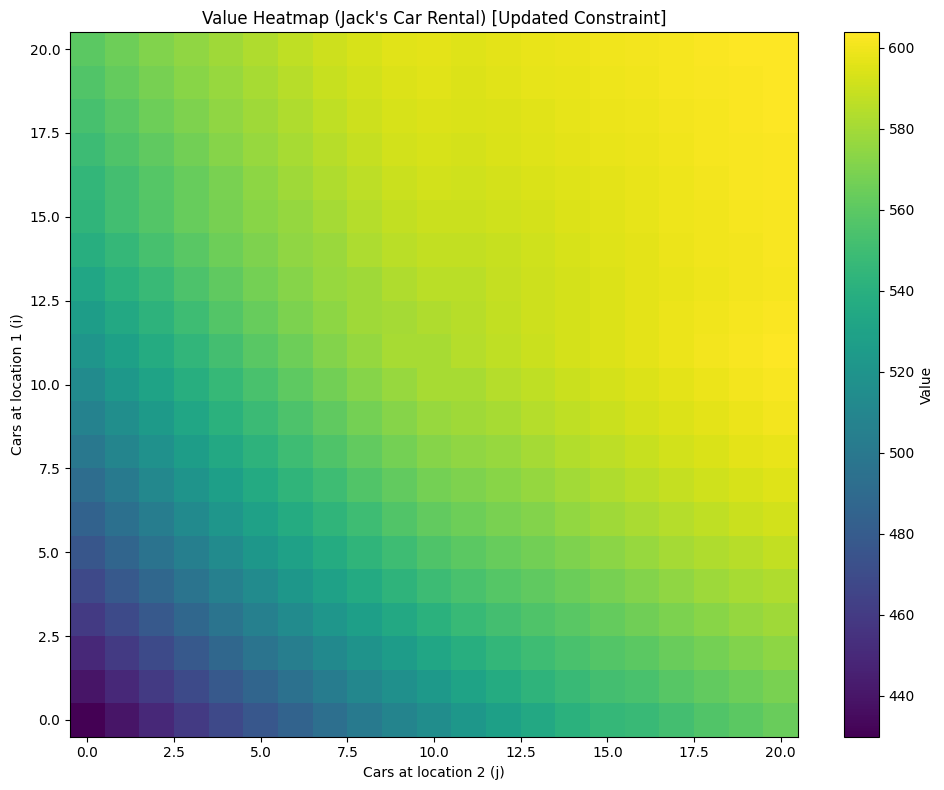

In [44]:
plot_heatmap(V, title = "Value Heatmap (Jack's Car Rental) [Updated Constraint]",
                 xlabel = "Cars at location 2 (j)", ylabel = "Cars at location 1 (i)")

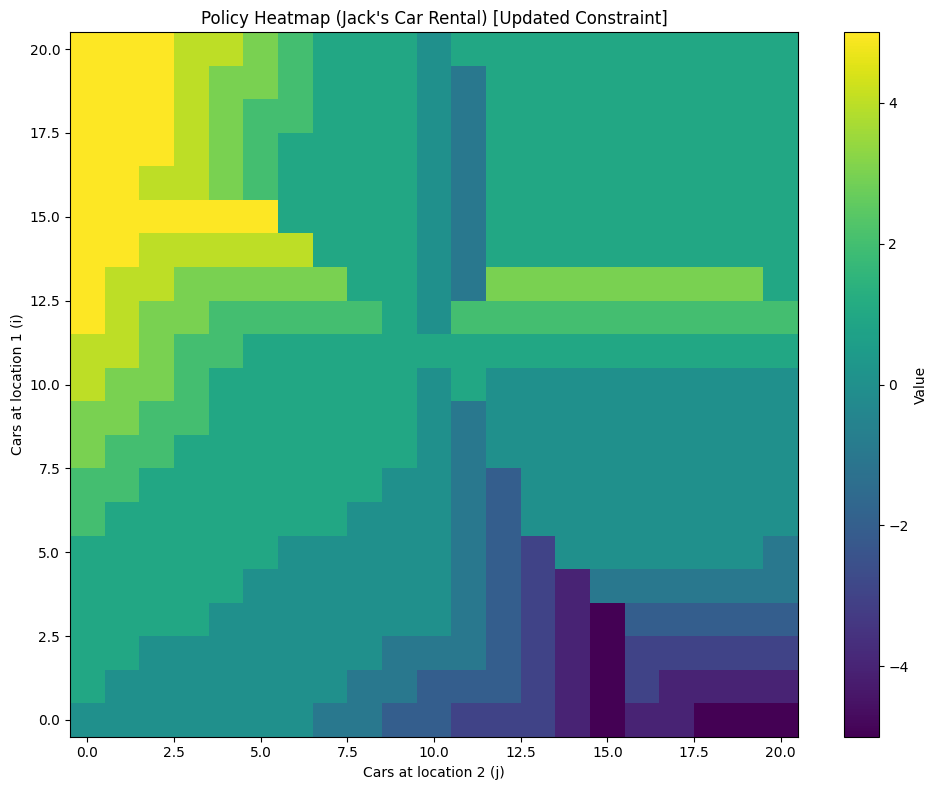

In [45]:
plot_heatmap(p, title = "Policy Heatmap (Jack's Car Rental) [Updated Constraint]",
                 xlabel = "Cars at location 2 (j)", ylabel = "Cars at location 1 (i)")

### Effect of free car transfer

The policy becomes more aggressive in moving cars from location 1 to location 2.

### Effect of parking penalty (> 10 cars overnight)

The value function flattens around inventory levels near 10.

States with very high inventory (close to 20) are less valuable than before.